<h1>Klasifikácia intenzity</h1>

<h4>Naimportovanie knižníc</h4>

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


<h4>Načítanie datasetu</h4>

In [30]:
# Načítanie datasetu
df = pd.read_csv("us_tornado_dataset_1950_2021.csv") 

<h4>Nevyhnutná úprava datasetu, pre vykonanie prvých modelov</h4>

In [31]:
# Odstránenie stĺpca 'date' z DataFrame 'df'
df.drop(['date'], axis=1, inplace=True)
# Odstránenie riadkov s hodnotou 'mag' rovnou -9 z DataFrame 'df'
df = df[df['mag'] != -9]

<h4>Funkcia pre prevedenie kategorických atribútov na číselné</h4>

In [32]:
# Definícia funkcie na one-hot encoding
def one_hot_encode(df, columns):
    
    return pd.get_dummies(df, columns=columns, drop_first=True)

<h4>Rozdelenie množiny na testovaciu a trénovaciu</h4>

In [33]:
# # Rozdelenie datasetu na trénovaciu a testovaciu sadu s 20% dátami pre testovanie
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mag'])

<h4>Vykonanie funkcie na zakódovanie kategorických atribútov</h4>

In [34]:
# One-hot encoding pre atribút 'st' na trénovacích a testovacích dátach
X_train = one_hot_encode(X_train, columns=['st'])
X_test = one_hot_encode(X_test, columns=['st'])

<h4>Rovnaké usporiadanie trénovacej a testovacej množiny</h4>

In [35]:
# Zisti atribúty v trénovacej, ktoré nie sú v testovacej
missing_in_test = set(X_train.columns) - set(X_test.columns)

# Pridá chýbajúce atribúty do testovacej a nastavi ich na 0
for column in missing_in_test:
    X_test[column] = 0

# Oddelí funkčné atribúty a cieľový atribút pre trénovaciu množinu
X_train, y_train = X_train.drop(columns=['mag']), X_train['mag']

# Oddelí funkčné atribúty a cieľový atribút pre testovaciu množinu
X_test, y_test = X_test.drop(columns=['mag']), X_test['mag']

# Získanie poradia stĺpcov z testovacej množiny
column_order = X_train.columns.tolist()

# Zoradenie stĺpcov trénovacej množiny podľa rovnakého poradia ako testovacia množina
X_test = X_test[column_order]


<h4>Vykonanie modelu Random forest na neupravenej a neoptimalizovanej množine</h4>

In [36]:
##RANDOM FOREST NA NEUPRAVENEJ MNOŽINE DAT 

# Inicializácia modelu Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Natrénovanie modelu
rf_classifier.fit(X_train, y_train)

# Predikcia na testovacích dátach
y_pred = rf_classifier.predict(X_test)

# Vyhodnotenie modelu pomocou confusion matrix a ďalších metrík
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Vypisanie metrík 
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.6711223956388619
Precision: 0.6608259486908775
Recall: 0.6711223956388619
F1 Score: 0.6614776770029487


<h4>Vykonanie modelu Rozhodovacie stromy na neupravenej a neoptimalizovanej množine</h4>

In [37]:
##DT NA NEUPRAVENEJ MNOŽINE DAT

# Inicializácia modelu Rozhodovacie Stromy
dt_model = DecisionTreeClassifier(random_state=42)

# Natrénovanie modelu
dt_model.fit(X_train, y_train)

# Predikcia na testovacích dátach
y_pred = dt_model.predict(X_test)

# Vyhodnotenie modelu pomocou confusion matrix a ďalších metrík
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Vypisanie metrík 
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.5830781868419087
Precision: 0.5841980366953377
Recall: 0.5830781868419087
F1 Score: 0.5836019658533086


<h4>Vykonanie modelu XGBoost na neupravenej a neoptimalizovanej množine</h4>

In [38]:
##XGBOOST NA NEUPRAVENEJ MNOŽINE DAT

num_classes = len(np.unique(y_train))  # Počet jedinečných tried dátach

# Inicializácia XGBoost klasifikátora s požadovanými parametrami
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Pre viacnásobnú klasifikáciu
    num_class=num_classes,  # Počet tried v dátach
    eval_metric='mlogloss',  # Hodnotenie metriky pre viacnásobnú klasifikáciu
    max_depth=6,  # Maximálna hĺbka stromu
    learning_rate=0.1,  # Veľkosť kroku zmeny použitá pri aktualizácii na zabránenie pretrénovaniu
    n_estimators=100,  # Počet stromov (boosting rounds) na zostavenie
    gamma=0,  # Minimálna strata potrebná na ďalšie delenie
    subsample=0.8,  # Zlomok vzoriek použitých na prispôsobenie jednotlivých základných učiacich sa
    colsample_bytree=0.8,  # Zlomok príznakov náhodne vybraných pre každý strom
    random_state=42  # Seed náhodného čísla
)

# Trénovanie modelu XGBoost na trénovacích dátach
xgb_model.fit(X_train, y_train)

# Predikcia na testovacích dátach
y_pred = xgb_model.predict(X_test)

# Vyhodnotenie modelu pomocou confusion matrix a ďalších metrík
accuracy = accuracy_score(y_test, y_pred)  
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

# Výpis metrík hodnotenia
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6573818236128743
Precision: 0.6442093138408462
Recall: 0.6573818236128743
F1 Score: 0.6453921719797476


<h4>Vykonanie modelu KNN na neupravenej množine</h4>

In [39]:
## KNN NA NEUPRAVENEJ MNOŽINE DAT

# Inicializácia modelu KNN
knn_model = KNeighborsClassifier()

# Natrénovanie modelu
knn_model.fit(X_train, y_train)

# Predikcia na testovacích dátach
y_pred = knn_model.predict(X_test)

# Vyhodnotenie modelu pomocou confusion matrix a ďalších metrík
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Vypisanie metrík 
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6117541632439698
Precision: 0.5900053460539089
Recall: 0.6117541632439698
F1 Score: 0.5957233149229764


<h4>Vykonanie modelu KNN na neupravenej množine s optimalizovanymi parametrami</h4>


KNN - neupravena, optimalizovana
Accuracy: 0.6434172205212456
Recall: 0.6434172205212456
Precision: 0.6256499226945296
F1 Score: 0.6283823671238546


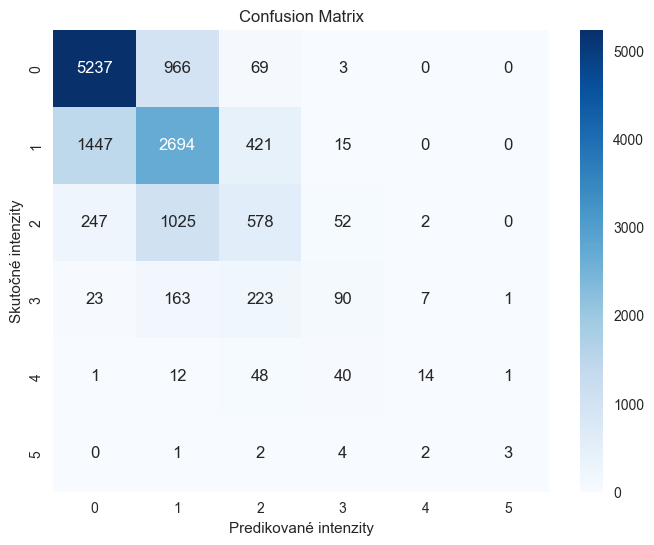

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


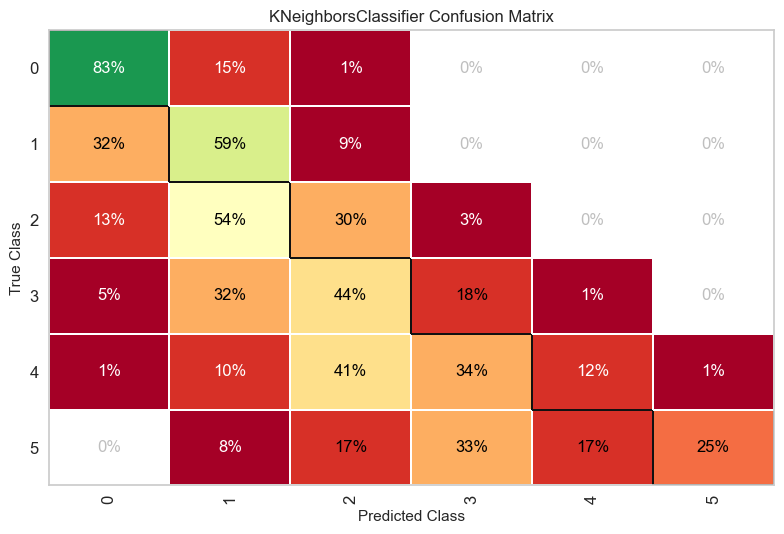

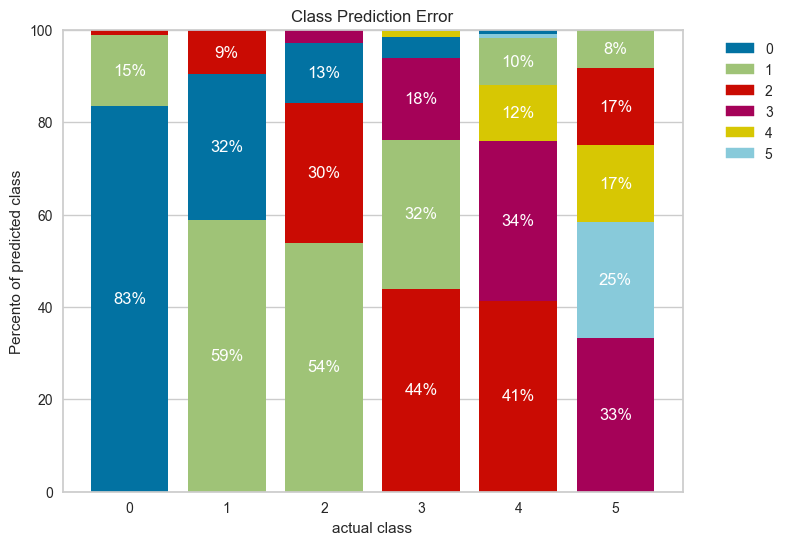

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


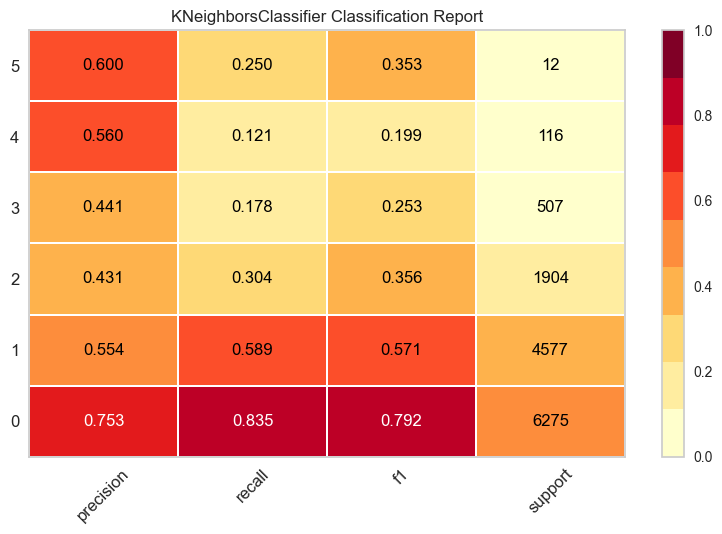

In [40]:
##KNN NA NEUPRAVENEJ MNOŽINE DAT S OPTIMALIZOVANÝMI PARAMETRAMI

# Inicializácia modelu KNN 
knn_model = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='manhattan')

# Vytvorenie funkcie pre vizualizáciu a vyhodnotenie modelu
def evaluate_model_visualization(model, X_train, y_train, X_test, y_test):
    classes = ["0", "1", "2","3","4","5"]
    # Trénovanie modelu
    model.fit(X_train, y_train)
    
    # Predikcia na testovacej množine
    y_pred = model.predict(X_test)
    
    # Výpočet confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Výpočet metrík presnosti, navrátnosti, úspešnosti a F1 skóre
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')  
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    
    # Vizualizácia confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predikované intenzity')
    plt.ylabel('Skutočné intenzity')
    plt.title('Confusion Matrix')
    plt.show()
    
    #Vizualizacia confussion matrix pomocou percent
    viz = ConfusionMatrix(model, percent = True, cmap="RdYlGn")
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    plt.figure(figsize=(8, 6))

    # Farby pre stĺpce
    colors = viz.class_colors_

    # Iterácia cez triedy
    for i in range(len(classes)):
        total = np.sum(conf_matrix[i])
        percentages = (conf_matrix[i] / total) * 100
        sorted_indexes = np.argsort(percentages)[::-1]  # Zoradené indexy podľa percentuálnych hodnôt, od najväčšej po najmenšiu
        bottom = 0
        # Iterácia cez zoradené percentá v jednotlivých triedach
        for j, idx in enumerate(sorted_indexes):
            percent = percentages[idx]
            # Získanie farby pre danú triedu
            color = colors[idx]
            # Zobrazenie stĺpca s percentuálnym podielom a farbou pre danú triedu
            plt.bar(classes[i], percent, bottom=bottom, color=color)
            # Označenie percentuálnych hodnôt vo vnútri stĺpca (iba pre percentá vyššie ako 5%)
            if percent > 5:
                plt.text(i, bottom + percent / 2, f'{int(np.round(percent))}%', ha='center', va='center', color='white')
            bottom += percent

    # Označenie osí
    plt.title('Class Prediction Error')
    plt.xlabel('actual class')
    plt.ylabel('Percento of predicted class')
    
    # Vytvorenie legendy
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]
    plt.legend(handles, classes, bbox_to_anchor=(1.05, 1), loc='upper left')

    #Zobrazenie grafu
    plt.show()
    
    # Vizualizácia ClassificationReport
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)         
    visualizer.show()                      

# Volanie funkcie na vyhodnotenie modelu KNN
print("\nKNN - neupravena, optimalizovana")
evaluate_model_visualization(knn_model, X_train, y_train, X_test, y_test)


<h3>Finálna úprava datasetu</h3>

<h4>Načítanie datasetu</h4>

In [41]:
# Načítanie datasetu
df = pd.read_csv("us_tornado_dataset_1950_2021.csv")

<h4>Úprava datasetu</h4>

In [42]:
# Odstránenie stĺpca 'date' z DataFrame 'df'
df.drop(['date'], axis=1, inplace=True)
# Odstránenie riadkov s hodnotou 'mag' rovnou -9 z DataFrame 'df'
df = df[df['mag'] != -9]
# Vytvorenie binárneho stĺpca 'fat_bin' na základe podmienky stĺpca 'fat'
df['fat_bin'] = df['fat'].apply(lambda x: 1 if x > 0 else 0)
# Odstránenie stĺpcov 'elat' a 'elon' z DataFrame 'df'
df.drop(['elat', 'elon'], axis=1, inplace=True)

<h4>Funkcia pre výpočet priemernej dĺžky a širky</h4>

In [43]:
def calculate_mean_values_before_encoding(train_df):
     # Vypočítanie priemerných hodnôt atribútu 'len' pre rôzne hodnoty atribútu 'mag'
    avg_len_by_mag = train_df[train_df['len'] != 0].groupby('mag')['len'].mean()
    # Vypočítanie priemerných hodnôt atribútu 'wid' pre rôzne hodnoty atribútu 'mag'
    avg_wid_by_mag = train_df[train_df['wid'] != 0].groupby('mag')['wid'].mean()
    
    # Vrátenie vypočítaných priemerných hodnôt
    return avg_len_by_mag, avg_wid_by_mag

<h4>Funkcia pre nahradenie chýbajúcich hodnôt priemerom</h4>

In [44]:
def preprocess_data(train_df, avg_len_by_mag, avg_wid_by_mag):
    # Nahradenie nulových hodnôt atribútu 'len' priemerom podľa hodnoty atribútu 'mag'
    train_df.loc[train_df['len'] == 0, 'len'] = train_df.loc[train_df['len'] == 0, 'mag'].map(avg_len_by_mag)
    # Nahradenie nulových hodnôt atribútu 'wid' priemerom podľa hodnoty atribútu 'mag'
    train_df.loc[train_df['wid'] == 0, 'wid'] = train_df.loc[train_df['wid'] == 0, 'mag'].map(avg_wid_by_mag)
    
    return train_df

<h4>Použitie funkcií</h4>

In [45]:
# Vypočítanie priemerných hodnôt 'len' a 'wid' pre rôzne hodnoty 'mag'
avg_len_by_mag, avg_wid_by_mag = calculate_mean_values_before_encoding(df)

<h4>Normalizácia pre atribúty 'wid' a 'len'</h4>

In [46]:
# Inicializácia MinMaxScaleru s rozsahom hodnôt od 0 do 4
scaler = MinMaxScaler(feature_range=(0, 4))  

# Normalizácia stĺpca 'wid' na rozsah 0-4
df['wid'] = scaler.fit_transform(df[['wid']])

# Normalizácia stĺpca 'len' na rozsah 0-4
df['len'] = scaler.fit_transform(df[['len']])

<h4>Rozdelenie na trénovaciu a testovaciu množinu</h4>

In [47]:
# Rozdelenie datasetu na trénovaciu a testovaciu sadu s 20% dátami pre testovanie
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mag'])

<h4>Použitie funkcií</h4>

In [48]:
# Predspracovanie trénovacieho datasetu s použitím priemerných hodnôt 'len' a 'wid'
train_df = preprocess_data(train_df, avg_len_by_mag, avg_wid_by_mag)

# Zakódovanie kategorickeho stĺpca v testovacej sade
test_df = one_hot_encode(test_df, columns=['st'])

# Zakódovanie kategorickeho stĺpca v trénovacej sade
train_df = one_hot_encode(train_df, columns=['st'])

<h4>Rovnaké usporiadanie trénovacej a testovacej množiny</h4>

In [49]:
# Zisti atribúty v trénovacej, ktoré nie sú v testovacej
missing_in_test = set(train_df.columns) - set(test_df.columns)

# Pridaj chýbajúce atribúty do testovacej a nastav ich na 0
for column in missing_in_test:
    test_df[column] = 0

# Oddelí funkčné atribúty a cieľový atribút pre trénovaciu množinu
X_train, y_train = train_df.drop(columns=['mag']), train_df['mag']
# Oddelí funkčné atribúty a cieľový atribút pre testovaciu množinu
X_test, y_test = test_df.drop(columns=['mag']), test_df['mag']

# Získanie poradia stĺpcov z testovacej množiny
column_order = X_train.columns.tolist()

# Zoradenie stĺpcov trénovacej množiny podľa rovnakého poradia ako testovacia množina
X_test = X_test[column_order]

<h4>Vytvorenie vybalansovanej trénovacej množiny pomocou metódy SMOTE</h4>

In [50]:
# Inicializácia SMOTE
smote = SMOTE(random_state=42)

# Aplikovanie SMOTE na trénovaciu množinu
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

<h4>Vytvorenie vybalansovanej trénovacej množiny pomocou metódy RandomOverSanpler</h4>

In [51]:
# Inicializácia Random Oversampler
ros = RandomOverSampler(random_state=42)

# Aplikovanie Random Oversampling na trénovaciu množinu
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)


<h4>Vytvorenie vybalansovanej trénovacej množiny pomocou metódy RandomUnderSampler</h4>

In [52]:
# Inicializácia Random Undersampler
rus = RandomUnderSampler(random_state=42)

# Aplikovanie Random Undersampling na trénovaciu množinu
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

<h4>Vytvorenie neoptimalizovaných modelov</h4>

In [53]:
num_classes = len(np.unique(y_train))  # Počet jedinečných tried v dátach

# Neupravené modely

# Random Forest klasifikátor s predvolenými parametrami
rf_model_n = RandomForestClassifier(random_state=42)
# Decision Tree klasifikátor s predvolenými parametrami  
dt_model_n = DecisionTreeClassifier(random_state=42) 
# K-Nearest Neighbors klasifikátor s predvolenými parametrami
knn_model_n = KNeighborsClassifier()  

# Model XGBoost s predvolenými parametrami
xgb_model_n = XGBClassifier(
    objective='multi:softmax',  # Pre viacnásobnú klasifikáciu
    num_class=num_classes,  # Počet tried vo vašich dátach
    eval_metric='mlogloss',  # Hodnotenie metriky pre viacnásobnú klasifikáciu
    max_depth=6,  # Maximálna hĺbka stromu
    learning_rate=0.1,  # Veľkosť kroku zmeny použitá pri aktualizácii na zabránenie pretrénovaniu
    n_estimators=100,  # Počet stromov (boosting rounds) na zostavenie
    gamma=0,  # Minimálna strata potrebná na ďalšie delenie
    subsample=0.8,  # Zlomok vzoriek použitých na prispôsobenie jednotlivých základných učiacich sa
    colsample_bytree=0.8,  # Zlomok príznakov náhodne vybraných pre každý strom
    random_state=42  # Seed náhodného čísla
)

<h4>Vytvorenie optimalizovaných modelov</h4>

In [54]:
# Model Random Forest s optimalizovanými parametrami
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400, random_state=42)

# Model Decision Tree s optimalizovanými parametrami
dt_model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=None, min_samples_leaf=16, min_samples_split=200, ccp_alpha=0.0001)

# Model K-Nearest Neighbors s optimalizovanými parametrami
knn_model = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='manhattan')

# Model XGBoost s ďalšími optimalizovanými parametrami
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Pre viacnásobnú klasifikáciu
    num_class=num_classes,  # Počet tried vo vašich dátach
    eval_metric='mlogloss',  # Hodnotenie metriky pre viacnásobnú klasifikáciu
    max_depth=None,  # Bez obmedzenia hĺbky stromu
    learning_rate=0.1,  # Veľkosť kroku zmeny použitá pri aktualizácii na zabránenie pretrénovaniu
    n_estimators=700,  # Počet stromov (boosting rounds) na zostavenie
    gamma=0,  # Minimálna strata potrebná na ďalšie delenie
    subsample=1,  # Všetky vzorky použité na prispôsobenie jednotlivých základných učiacich sa
    colsample_bytree=1,  # Všetky príznaky použité pre každý strom
    random_state=42  # Seed náhodného čísla
)

<h4>Vytvorenie fukcie pre vyhodnotenie modelu bez vizualizácie</h4>

In [55]:
# Funkcia pre vyhodnotenie modelu
def evaluate_model(model, X_train, y_train, X_test, y_test):
    classes = ["0", "1", "2","3","4","5"]  # Zoznam tried modelu

    # Trénovanie modelu na trénovacích dátach
    model.fit(X_train, y_train)
    
    # Predikcia na testovacej množine
    y_pred = model.predict(X_test)
    
    # Výpočet confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Výpočet metrík presnosti, návratnosti, úspešnosti a F1 skóre
    accuracy = accuracy_score(y_test, y_pred) 
    recall = recall_score(y_test, y_pred, average='weighted')  
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1) 
    f1 = f1_score(y_test, y_pred, average='weighted') 

    # Výpis metrík hodnotenia
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)


<h4>Vyhodnotenie jednotlivých modelov na rôzne upravených trénovacích dátach, najlepšie modely vyhodnotené aj vizuálne</h4>


RF - nevyvazeny - upravená množina - neoptimalizovany
Accuracy: 0.671943842879546
Recall: 0.671943842879546
Precision: 0.6621121736635778
F1 Score: 0.6625531589592478

RF - nevyvazeny - upravená množina - optimalizovany
Accuracy: 0.6754536629079232
Recall: 0.6754536629079232
Precision: 0.666232795254364
F1 Score: 0.6650470968216262

RF - SMOTE - upravená množina - optimalizovany
Accuracy: 0.6664177432603988
Recall: 0.6664177432603988
Precision: 0.6710847851156612
F1 Score: 0.6684114308932607

RF - OVER - upravená množina - optimalizovany
Accuracy: 0.6710477186169815
Recall: 0.6710477186169815
Precision: 0.6714067060483768
F1 Score: 0.6697851558813875


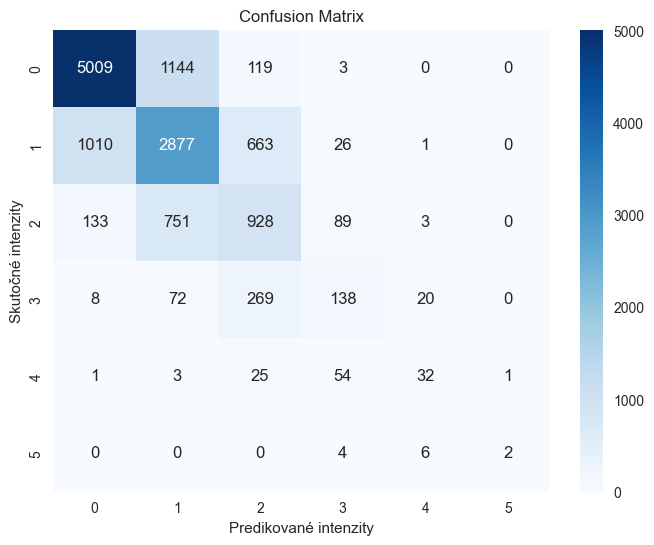

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


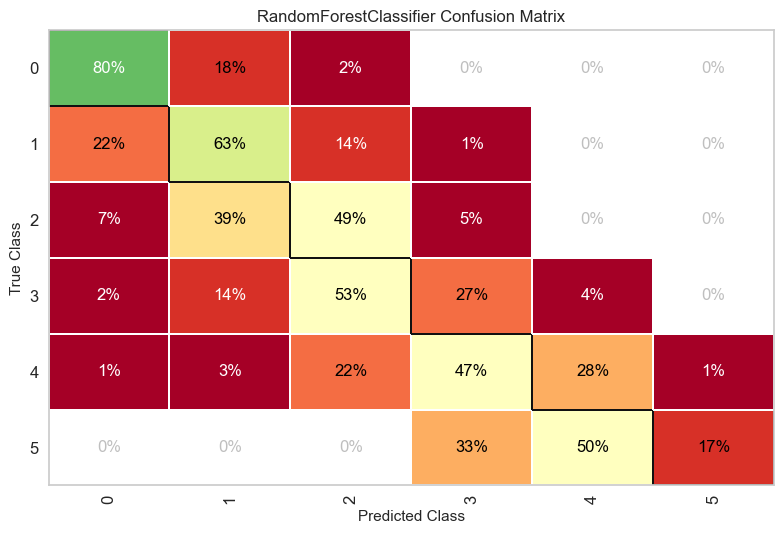

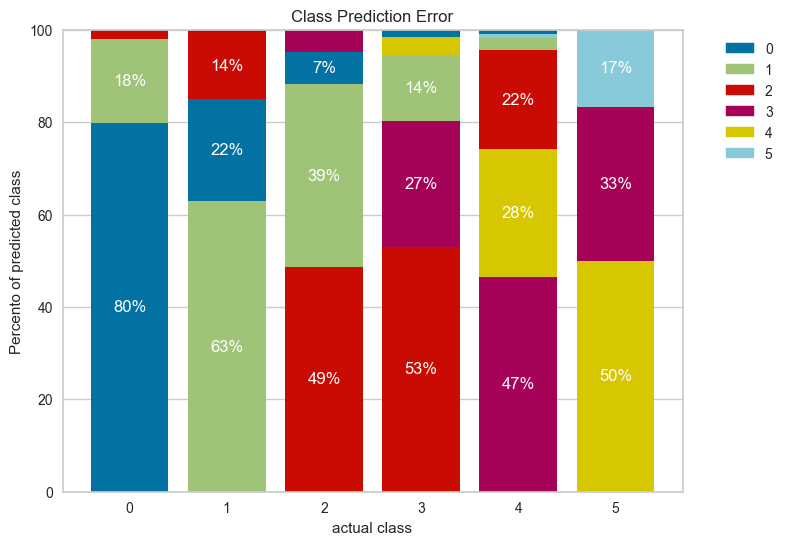

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


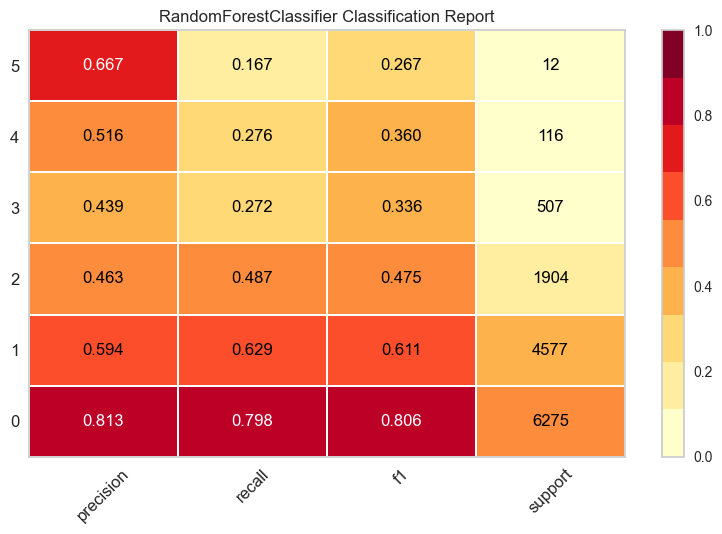


RF - UNDER - upravená množina - optimalizovany
Accuracy: 0.5300575013068479
Recall: 0.5300575013068479
Precision: 0.5440071968230549
F1 Score: 0.5313544489954299

DT - nevyvazeny - upravená množina - neoptimalizovany
Accuracy: 0.5830781868419087
Recall: 0.5830781868419087
Precision: 0.5831130395274456
F1 Score: 0.5830811752540379

DT - nevyvážený - upravená množina - optimalizovany
Accuracy: 0.6354267791800463
Recall: 0.6354267791800463
Precision: 0.6254735628800641
F1 Score: 0.6245921051553478


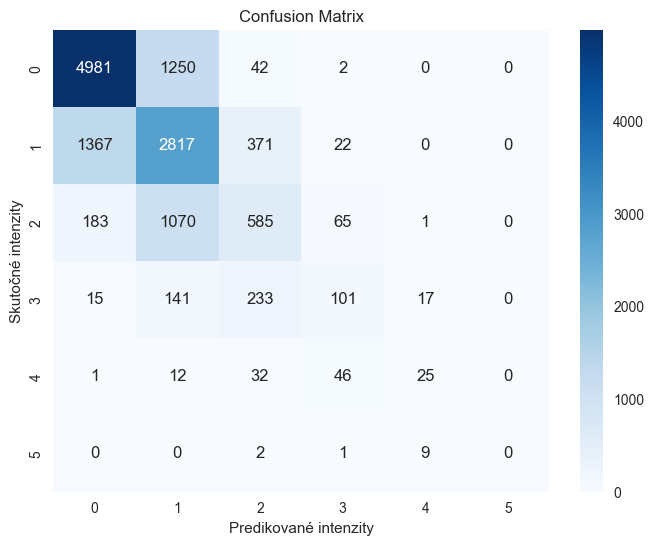

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


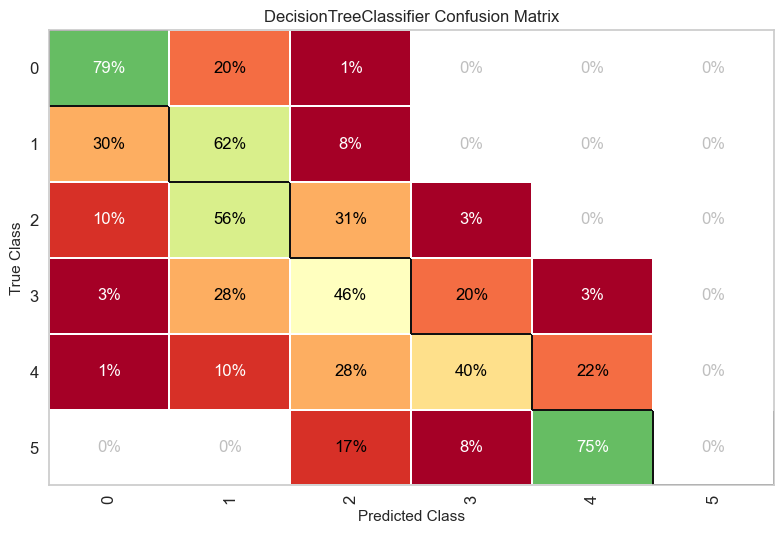

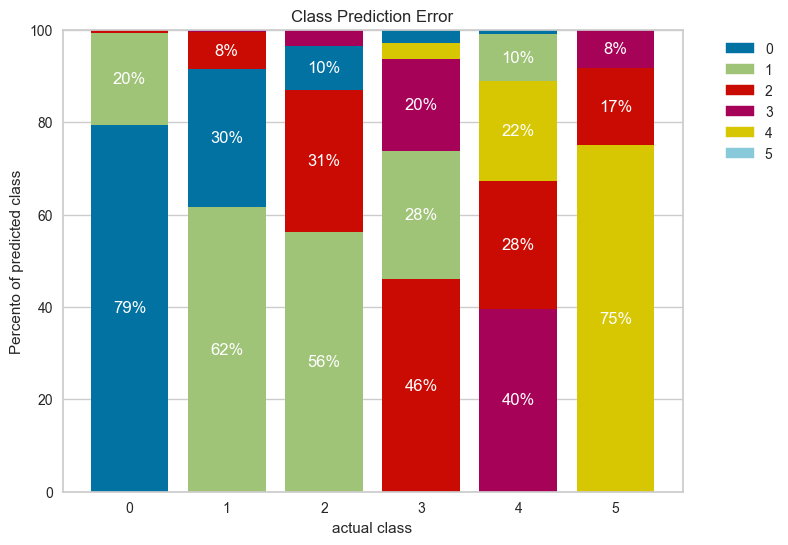

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


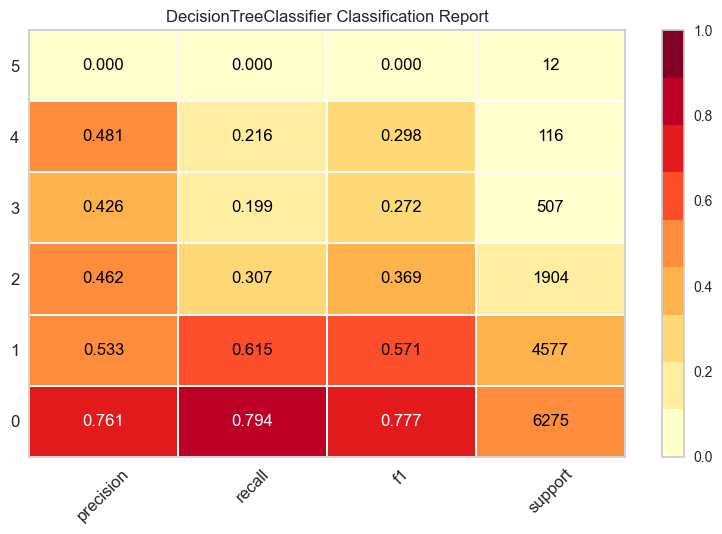


DT - SMOTE - upravená množina - optimalizovane
Accuracy: 0.586588006870286
Recall: 0.586588006870286
Precision: 0.61340882974884
F1 Score: 0.5974509052424876

DT - OVER - upravená množina - optimalizovane
Accuracy: 0.5751624225225898
Recall: 0.5751624225225898
Precision: 0.6101378513472702
F1 Score: 0.5887718903360981

DT - UNDER - upravená množina - optimalizovane
Accuracy: 0.48248823836905386
Recall: 0.48248823836905386
Precision: 0.7450193451283722
F1 Score: 0.33093686416911594

KNN - nevyvazeny - upravená množina - neoptimalizovany
Accuracy: 0.5559704278993354
Recall: 0.5559704278993354
Precision: 0.532582482457943
F1 Score: 0.5359091812196728

KNN - nevyvážené - upravená množina - optimalizovane
Accuracy: 0.5800164289448136
Recall: 0.5800164289448136
Precision: 0.5580922915932383
F1 Score: 0.5591506668212939

KNN - SMOTE - upravená množina - optimalizovaných
Accuracy: 0.5392427749981331
Recall: 0.5392427749981331
Precision: 0.5630101345435432
F1 Score: 0.5488133014200625

KNN - O

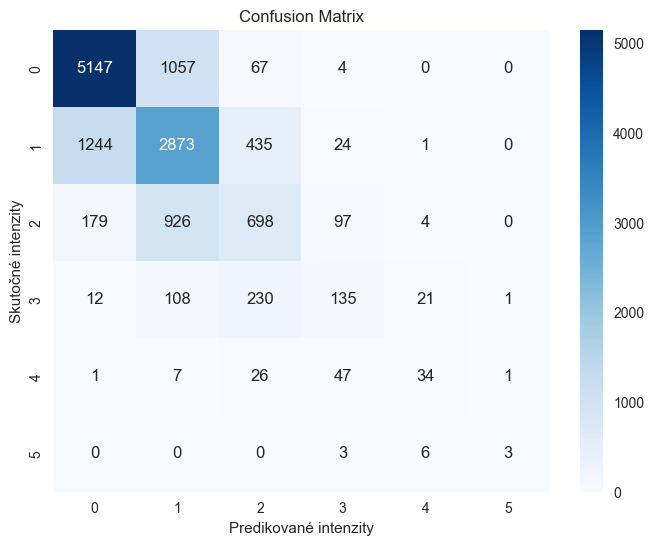

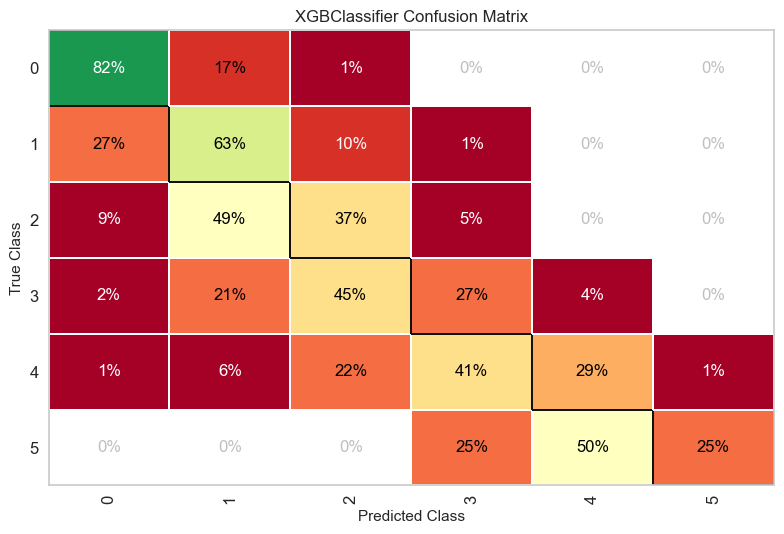

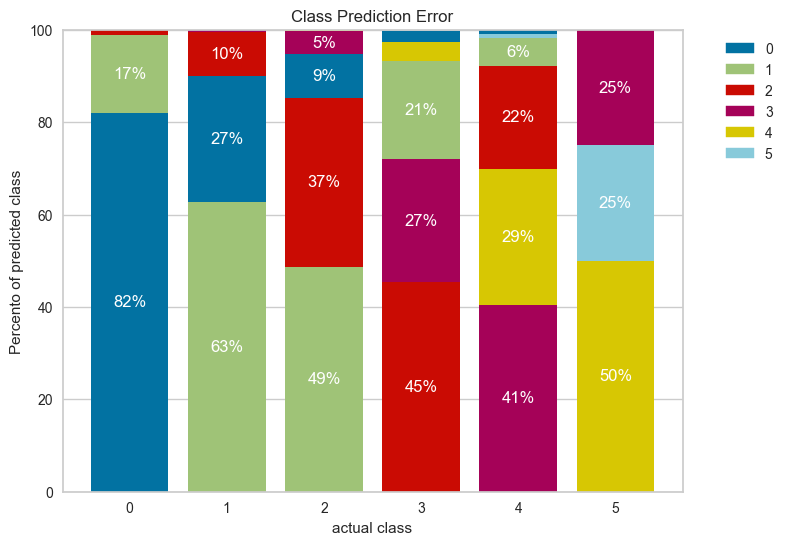

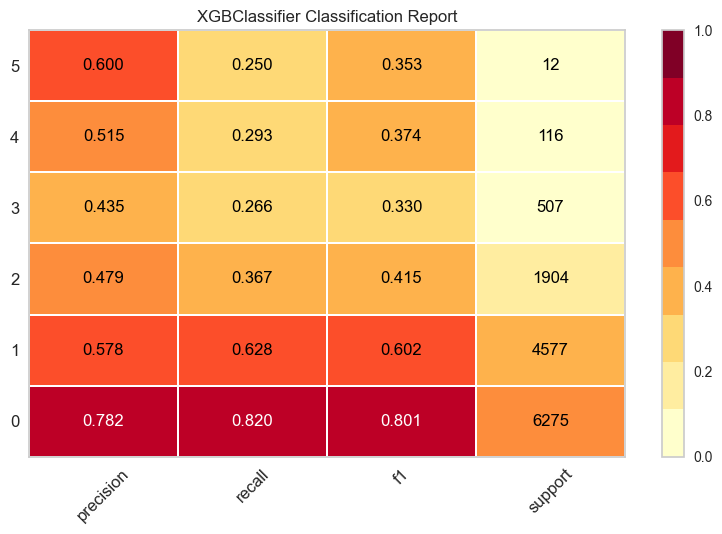


XGB - SMOTE - upravená množina - optimalizovaných
Accuracy: 0.6529758793219327
Recall: 0.6529758793219327
Precision: 0.651913636890085
F1 Score: 0.6522680451676003

XGB - OVER - upravená množina - optimalizovaných
Accuracy: 0.6410275558210738
Recall: 0.6410275558210738
Precision: 0.6534979451837728
F1 Score: 0.6458673363480092

XGB - UNDER - upravená množina - optimalizovaných
Accuracy: 0.4976476738107684
Recall: 0.4976476738107684
Precision: 0.5320887724221549
F1 Score: 0.5094677700172119


In [56]:
##Skušal som všetky vybalancovania tieto vyhrali pre modely   
print("\nRF - nevyvazeny - upravená množina - neoptimalizovany")
evaluate_model(rf_model_n, X_train, y_train, X_test, y_test)

print("\nRF - nevyvazeny - upravená množina - optimalizovany")
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

print("\nRF - SMOTE - upravená množina - optimalizovany")
evaluate_model(rf_model, X_train_smote, y_train_smote, X_test, y_test)

print("\nRF - OVER - upravená množina - optimalizovany")
evaluate_model_visualization(rf_model, X_train_over, y_train_over, X_test, y_test)

print("\nRF - UNDER - upravená množina - optimalizovany")
evaluate_model(rf_model, X_train_under, y_train_under, X_test, y_test)

print("\nDT - nevyvazeny - upravená množina - neoptimalizovany")
evaluate_model(dt_model_n, X_train, y_train, X_test, y_test)

print("\nDT - nevyvážený - upravená množina - optimalizovany")
evaluate_model_visualization(dt_model, X_train, y_train, X_test, y_test)

print("\nDT - SMOTE - upravená množina - optimalizovane")
evaluate_model(dt_model, X_train_smote, y_train_smote, X_test, y_test)

print("\nDT - OVER - upravená množina - optimalizovane")
evaluate_model(dt_model, X_train_over, y_train_over, X_test, y_test)

print("\nDT - UNDER - upravená množina - optimalizovane")
evaluate_model(dt_model, X_train_under, y_train_under, X_test, y_test)

print("\nKNN - nevyvazeny - upravená množina - neoptimalizovany")
evaluate_model(knn_model_n, X_train, y_train, X_test, y_test)

print("\nKNN - nevyvážené - upravená množina - optimalizovane")
evaluate_model(knn_model, X_train, y_train, X_test, y_test)

print("\nKNN - SMOTE - upravená množina - optimalizovaných")
evaluate_model(knn_model, X_train_smote, y_train_smote, X_test, y_test)

print("\nKNN - OVER - upravená množina - optimalizovaných")
evaluate_model(knn_model, X_train_over, y_train_over, X_test, y_test)

print("\nKNN - UNDER - upravená množina - optimalizovaných")
evaluate_model(knn_model, X_train_under, y_train_under, X_test, y_test)

print("\nXGB - nevyvážené - upravená množina - neoptimalizovane")
evaluate_model(xgb_model_n, X_train, y_train, X_test, y_test)

print("\nXGB - nevyvážené - upravená množina - optimalizovane")
evaluate_model_visualization(xgb_model, X_train, y_train, X_test, y_test)

print("\nXGB - SMOTE - upravená množina - optimalizovaných")
evaluate_model(xgb_model, X_train_smote, y_train_smote, X_test, y_test)

print("\nXGB - OVER - upravená množina - optimalizovaných")
evaluate_model(xgb_model, X_train_over, y_train_over, X_test, y_test)

print("\nXGB - UNDER - upravená množina - optimalizovaných")
evaluate_model(xgb_model, X_train_under, y_train_under, X_test, y_test)
